# sparkmagic

In [1]:
# Load sparkmagic
%load_ext sparkmagic.magics

In [2]:
# Magic help
%spark?

In [3]:
# Create a Spark session
%spark add -s session -l python -t None -u http://localhost:8998

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1537134958699_0001,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [4]:
# View running sessions
%spark info

Info for running Spark:
    Sessions:
        Name: session	Session id: 0	YARN id: application_1537134958699_0001	Kind: pyspark	State: idle
	Spark UI: http://ip-172-31-28-122.eu-west-1.compute.internal:20888/proxy/application_1537134958699_0001/
	Driver Log: http://ip-172-31-27-244.eu-west-1.compute.internal:8042/node/containerlogs/container_1537134958699_0001_01_000001/livy
    Session configs:
        {}



In [ ]:
%spark delete -s session

In [ ]:
%spark cleanup

### Run code in Spark session

In [5]:
%%spark
print('Hello, world!')

Hello, world!

### Code in Spark cells is run in the cluster

In [6]:
%%spark
from __future__ import print_function
import socket
import platform
print('Running Python', platform.python_version(), 'on', socket.gethostname())

Running Python 2.7.14 on ip-172-31-28-122

In [7]:
import socket
import platform
print('Running Python', platform.python_version(), 'on', socket.gethostname())

Running Python 3.6.5 on cube-df677411-c8ad-4575-9448-ff194d35c6ac-77d45cdc8-b5znp


### Load some data into Spark

Loading the Amazon product reviews dataset from Amazon S3 in Parquet format using `spark.read` as a Spark DataFrame:

In [8]:
%%spark
data_url = 's3://amazon-reviews-pds/parquet/'
df = spark.read.parquet(data_url)

Other data formats available, including:

* Plain text
* CSV
* JSON
* JDBC database connectors

See: http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader

### Check data structure

Use `.printSchema()` to check the structure of DataFrames, without needing to evaluate them.

In [9]:
%%spark
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)

### Caching

Cache data for faster iteration.

In [10]:
%%spark
df_cached = df.cache()
print(df_cached.count())

160796570

### Do some analysis!

In [11]:
%%spark
star_rating_counts = (
    df_cached
    .groupBy('star_rating')
    .count()
    .orderBy('star_rating')
)

In [12]:
%%spark
star_rating_counts.printSchema()
star_rating_counts.show()

root
 |-- star_rating: integer (nullable = true)
 |-- count: long (nullable = false)

+-----------+--------+
|star_rating|   count|
+-----------+--------+
|          1|12667601|
|          2| 7700647|
|          3|12900929|
|          4|27996469|
|          5|99530924|
+-----------+--------+

### Retrieve data from cluster into Jupyter

In [13]:
%spark -o star_rating_counts

In [14]:
# Now a Pandas DataFrame 
star_rating_counts

,star_rating,count
0,1,12667601
1,2,7700647
2,3,12900929
3,4,27996469
4,5,99530924


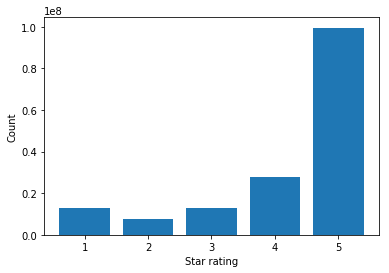

In [15]:
from matplotlib import pyplot
%matplotlib inline

pyplot.bar(
    star_rating_counts['star_rating'],
    star_rating_counts['count']
)

pyplot.xlabel('Star rating')
pyplot.ylabel('Count');

# Spark MLlib

### Tokenise review bodies

In [16]:
%%spark
from pyspark.ml.feature import Tokenizer

df_cleaned = df_cached.na.fill({'review_body': ''})

tokenizer = Tokenizer(
    inputCol='review_body',
    outputCol='words'
)
df_with_words = tokenizer.transform(df_cleaned)

### Count words

In [17]:
%%spark
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

countTokens = udf(
    lambda words: len(words),
    IntegerType()
)

df_with_word_count = df_with_words.withColumn(
    'num_words',
    countTokens(df_with_words.words)
).cache()

### Bin data

In [18]:
%%spark
from pyspark.sql.functions import col, floor
binned = df_with_word_count.filter(
    col('num_words') < 2000
).select(
    floor(col('num_words') / 20).alias('bin')
).groupBy('bin').count().orderBy('bin')

words_hist = binned.select(
    (col('bin') * 20).alias('num_words'),
    col('count')
)

In [19]:
%spark -o words_hist

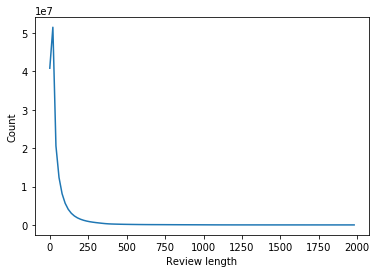

In [20]:
pyplot.plot(words_hist['num_words'], words_hist['count'])
pyplot.xlabel('Review length')
pyplot.ylabel('Count');